<a href="https://colab.research.google.com/github/limshaocong/analyticsEdge/blob/main/FAANG_Volume_Prediction_caa%2023Nov21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Preliminaries**

In [1]:
suppressMessages(library(tidyverse)) # generic must have package
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2)) # plotting package
suppressMessages(library(lubridate)) # easy comprehension of dates from string to correct datetime format
suppressMessages(library(data.table))
suppressMessages(library(purrr)) # reduce
if("patchwork" %in% rownames(installed.packages()) == FALSE) {install.packages("patchwork")}
suppressMessages(library(patchwork))
if("caret" %in% rownames(installed.packages()) == FALSE) {install.packages("caret")}
suppressMessages(library(caret))

options(repr.plot.width = 10,
        repr.plot.height = 9,
        repr.plot.pointsize = 20)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘future.apply’, ‘progressr’, ‘numDeriv’, ‘SQUAREM’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘gower’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’




Import data and check for any NA within the file

In [9]:
path = "https://raw.githubusercontent.com/limshaocong/analyticsEdge/main/Datasets/FAANG/altdata.csv"
df = read.csv(path) %>% mutate(date = ymd(date))

if (dim(df)[1] == dim(na.omit(df))[1]) {
  print("No missing data.")
} else {
  print("Missing data")
}

[1] "No missing data."


# **Exploratory Analysis**

Overview of Data

In [10]:
head(df, 5)

,date,ticker,open,close,high,low,vol,newssentiment,newsmentions,twtrmentions,twtrsentiment,wsbsentiment,wsbmentions,pricetarget,voltarget
,<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<int>
1,2019-01-02,FB,128.99,135.68,137.51,128.56,28142593,50,2,606,0.11716172,0.1814700,1,131.74,22716248
2,2019-01-03,FB,134.69,131.74,137.17,131.12,22716248,50,0,521,0.03071017,-0.1376714,1,137.95,29000732
3,2019-01-04,FB,134.01,137.95,138.00,133.75,29000732,50,0,431,0.05800464,-0.0623300,1,138.05,20088916
4,2019-01-07,FB,137.56,138.05,138.87,135.91,20088916,50,0,415,0.20240964,-0.2222167,1,142.53,26252863
5,2019-01-08,FB,139.89,142.53,143.14,139.54,26252863,63,2,569,0.26889279,0.3528667,1,144.23,22203279


671 trading days worth of training data from Jan 1, 2019 to Aug 30, 2021.

In [11]:
df %>%
  group_by(ticker) %>%
  summarise(n())

ticker,n()
<chr>,<int>
AAPL,671
AMZN,671
FB,671
GOOGL,671
NFLX,671


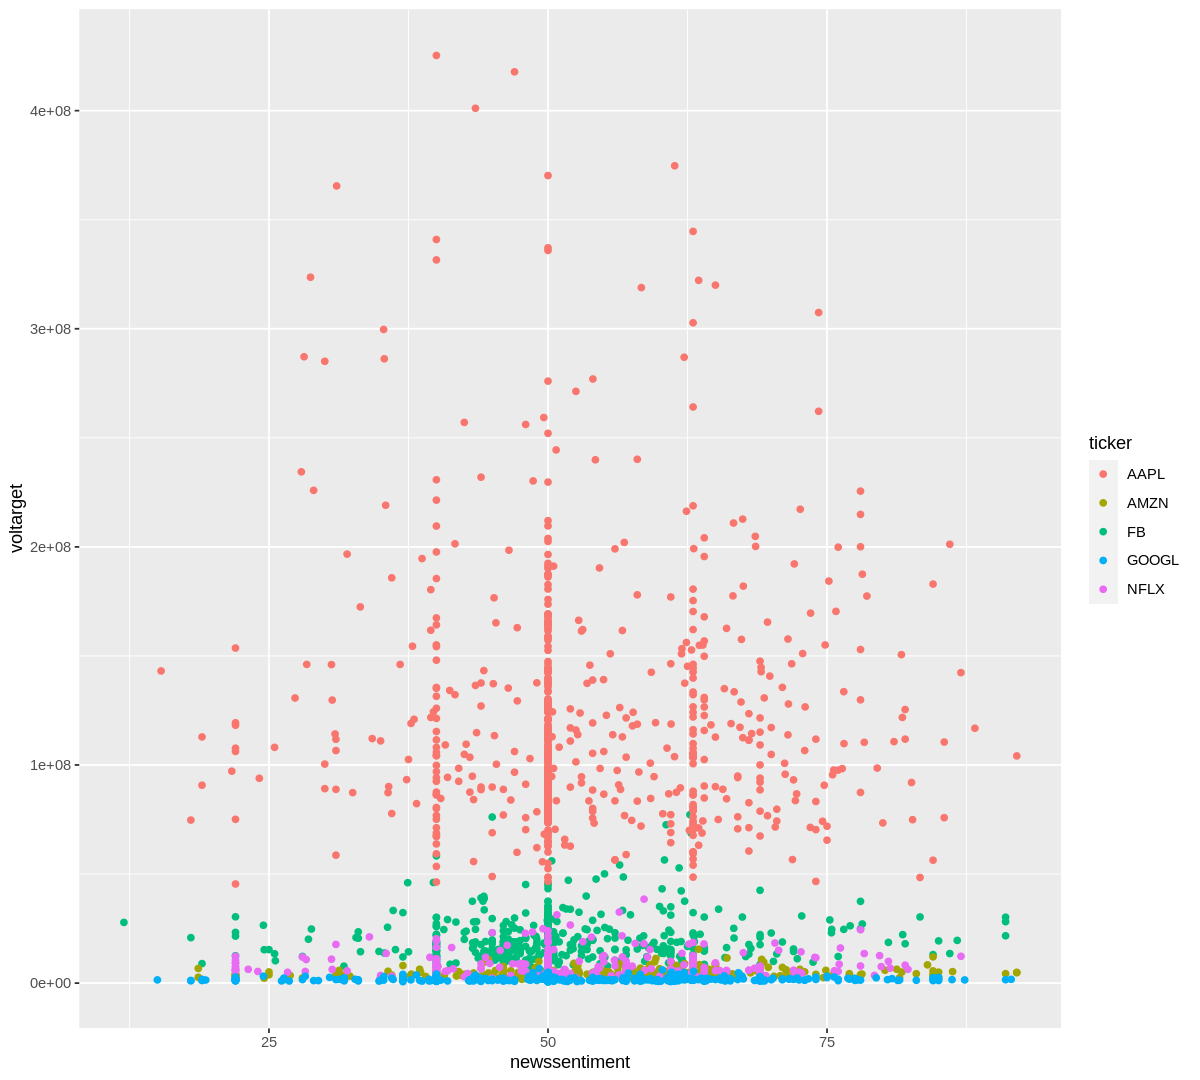

In [67]:
ggplot(data = df) +
geom_point(aes(x = newssentiment, y = voltarget, colour = ticker))

# **Data Preparation**

Train-test split

In [48]:
split = as.Date("2020-12-23")

# Train-test split
train = df %>% filter(date < split)
test = df %>% filter(date >= split)

train_days = dim(train)[1]/5
test_days = dim(test)[1]/5

train_prop = train_days / (train_days + test_days)

paste0("Training data proportion: ", round(train_prop * 100, 1), "%. Total training days = ", train_days)

[1] "Training data proportion: 74.4%. Total training days = 499"

Train-validate Split - as normal k-fold CV does not work on time series, an expanding window approach is used (see Section 4.3 of https://topepo.github.io/caret/data-splitting.html#time). With these parameters, CV-error will be run on 5 different validation sets.

In [49]:
index = 1:train_days
slices = createTimeSlices(index, initialWindow = 225, horizon = 100, fixedWindow = FALSE, skip = 28)

trainslices = slices[[1]] # specific slices callable by df[trainslices[[i]],]
testslices = slices[[2]]

lapply(slices, length)

$train
[1] 7

$test
[1] 7

In [62]:
for (fold in 1:7) {
  trainN = length(slices$train[[fold]])
  testN = length(slices$test[[fold]])
  trainperc = round(trainN / (trainN + testN), 2) * 100

  print(paste0("Fold ", fold, ": ", trainN, " train data. 100 test data. ", trainperc, "%"))
}

[1] "Fold 1: 225 train data. 100 test data. 69%"
[1] "Fold 2: 254 train data. 100 test data. 72%"
[1] "Fold 3: 283 train data. 100 test data. 74%"
[1] "Fold 4: 312 train data. 100 test data. 76%"
[1] "Fold 5: 341 train data. 100 test data. 77%"
[1] "Fold 6: 370 train data. 100 test data. 79%"
[1] "Fold 7: 399 train data. 100 test data. 80%"


In [52]:
slices$train
slices$test

$Training225
  [1]   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
 [19]  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
 [37]  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
 [55]  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
 [73]  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
 [91]  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
[109] 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
[127] 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
[145] 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
[163] 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
[181] 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
[199] 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
[217] 217 218 219 220 221 222 223 224 225

$Training254
  [1]   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
 [19]  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
 [37]  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
 [55]  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
 [73]  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
 [91]  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
[109] 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
[127] 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
[145] 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
[163] 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
[181] 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
[199] 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
[217] 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
[235] 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252
[253] 253 254

$Training283
  [1]   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
 [19]  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
 [37]  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
 [55]  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
 [73]  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
 [91]  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
[109] 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
[127] 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
[145] 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
[163] 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
[181] 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
[199] 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
[217] 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
[235] 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252
[253] 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270
[271] 271 272 273 274 275 276 277 278 279 280 281 282 283

$Training312
  [1]   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
 [19]  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
 [37]  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
 [55]  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
 [73]  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
 [91]  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
[109] 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
[127] 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
[145] 145

$Testing225
  [1] 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243
 [19] 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261
 [37] 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279
 [55] 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297
 [73] 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315
 [91] 316 317 318 319 320 321 322 323 324 325

$Testing254
  [1] 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272
 [19] 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290
 [37] 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308
 [55] 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326
 [73] 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344
 [91] 345 346 347 348 349 350 351 352 353 354

$Testing283
  [1] 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301
 [19] 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319
 [37] 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337
 [55] 338 339 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355
 [73] 356 357 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373
 [91] 374 375 376 377 378 379 380 381 382 383

$Testing312
  [1] 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330
 [19] 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348
 [37] 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366
 [55] 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382 383 384
 [73] 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401 402
 [91] 403 404 405 406 407 408 409 410 411 412

$Testing341
  [1] 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359
 [19] 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377
 [37] 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395
 [55] 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413
 [73] 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430 431
 [91] 432 433 434 435 436 437 438 439 440 441

$Testing370
  [1] 371 372 373 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388
 [19] 389 390 391 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406
 [37] 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424
 [55] 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442
 [73] 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460
 [91] 461 462 463 464 465 466 467 468 469 470

$Testing399
  [1] 400 401 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417
 [19] 418 419 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435
 [37] 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453
 [55] 454 455 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471
 [73] 472 473 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489
 [91] 490 491 492 493 494 495 496 497 498 499

# **Model Building**

In [ ]:
suppressMessages(library(rpart.plot))
if("Metrics" %in% rownames(installed.packages()) == FALSE) {install.packages("Metrics")}
suppressMessages(library(Metrics))
if("glm2" %in% rownames(installed.packages()) == FALSE) {install.packages("glm2")}
suppressMessages(library(glm2))
if("xgboost" %in% rownames(installed.packages()) == FALSE) {install.packages("xgboost")}
library(xgboost)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘xgboost’


The following object is masked from ‘package:dplyr’:

    slice




In [72]:
install.packages("zoo")
library(zoo) # rolling mean

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




In [89]:
# Naive model using 5day MA

naive = df %>%
  group_by(ticker) %>%
  mutate(vol5MA = rollmean(vol, align = "right", k = 5, fill = NA)) %>%
  mutate(abserror = abs(vol5MA - vol)) %>%
  select(date, ticker, abserror)

naive

date,ticker,abserror
<date>,<chr>,<dbl>
2019-01-02,FB,NA
2019-01-03,FB,NA
2019-01-04,FB,NA
2019-01-07,FB,NA
2019-01-08,FB,1012592.6
2019-01-09,FB,1849128.6
2019-01-10,FB,6620114.8
2019-01-11,FB,6605647.6
2019-01-14,FB,917647.0


In [ ]:
# Function to construct CART tree
cart = function() {
  
  train_control = trainControl(method = "timeslice",
                            initialWindow = 130,
                            horizon = 30,
                            fixedWindow = FALSE,
                            skip = 40,
                            savePredictions = TRUE)

  # hyperparameters
  cp_values = data.frame(.cp = seq(0, 0.01, by = 0.0001))

  model = train(x = trainX,
                y = trainY,
                method = "rpart",
                trControl = train_control,
                tuneGrid = cp_values)

}

# Function to construct RandomForest
randomforest = function() {

  train_control = trainControl(method = "timeslice",
                                initialWindow = 130,
                                horizon = 30,
                                fixedWindow = FALSE,
                                skip = 40,
                                savePredictions = TRUE)

  # hyperparameters
  n_pred = dim(trainX)[2]
  mtry_low = 1
  mtry_upp = n_pred - 1
  mtry_grid = data.frame(mtry = seq(mtry_low, mtry_upp, by = 1))
      
  model = train(x = trainX,
                y = trainY,
                method = "rf",
                trControl = train_control,
                tuneGrid = mtry_grid,
                ntree = 150,
                nodesize = 5)

}

# Function to construct XGBoost
xgb = function() {
  
  train_control = trainControl(method = "timeslice",
                              initialWindow = 130,
                              horizon = 30,
                              fixedWindow = FALSE,
                              skip = 40,
                              savePredictions = TRUE,
                              allowParallel = TRUE)

  # hyperparameters that require further tuning
  parm_grid = expand.grid(nrounds = 100, 
                          max_depth = 6, 
                          eta = seq(0.01, 0.05, by = 0.001),
                          gamma = 0,
                          colsample_bytree = 1,
                          min_child_weight = 1,
                          subsample = c(0.3, 0.5))

  model = train(x = trainX,
                y = trainY,
                method = "xgbTree",
                tuneGrid = parm_grid,
                trControl = train_control)

}

# Function to plot 
plotlastfold = function(model) {
  
  train_pred = predict(model$finalModel, newdata = trainX)
  
  model_df = data.frame(timesteps = seq(1, train_days), predicted = train_pred, actual = trainY)

  ggplot(data = model_df, (aes(x = timesteps))) +
    geom_line(aes(y = predicted), color = "blue") +
    geom_line(aes(y = actual), color = "black")

}


In [ ]:
tick = "AAPL"

trainX = train %>% filter(ticker == tick) %>% select(c(7:15))
trainY = train %>% filter(ticker == tick) %>% select(c(17)) %>% pull()

testX = test %>% filter(ticker == tick) %>% select(c(7:15))
testY = test %>% filter(ticker == tick) %>% select(c(17)) %>% pull()

In [ ]:
# Construct a CART tree
tree = cart()

# cp= 0.0007 gives the lowest CV RMSE
tree$results %>% arrange(RMSE) %>% head()

,cp,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,7e-04,2927240,0.2127140,2234905,1627863,0.2082261,1207562
2,8e-04,2927240,0.2127140,2234905,1627863,0.2082261,1207562
3,0e+00,2928267,0.2117028,2236432,1627249,0.2084203,1206755
4,1e-04,2928267,0.2117028,2236432,1627249,0.2084203,1206755
5,2e-04,2928267,0.2117028,2236432,1627249,0.2084203,1206755
6,3e-04,2928267,0.2117028,2236432,1627249,0.2084203,1206755


In [ ]:
# Construct a RandomForest
forest = randomforest()

# mtry = 6 gives the lowest CV RMSE
forest$results %>% arrange(RMSE) %>% head()

mtry,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6,2466002,0.2939868,1867399,1174385,0.1876427,755612.2
7,2474914,0.2843725,1871015,1222379,0.1827553,791962.5
8,2487624,0.2836603,1901819,1171751,0.1847954,792465.7
4,2496128,0.2771847,1890202,1139840,0.1942951,760238.7
5,2503157,0.2783119,1891141,1179127,0.1886365,771827.9
2,2540587,0.2667488,1931056,1234808,0.1914192,833709.6
3,2541207,0.2712813,1933652,1238154,0.1608600,827965.9
1,2673128,0.2624575,2093825,1532242,0.1920181,1175744.0


In [ ]:
# Construct a XGBoost
xgboost = xgb()

#xgboost$bestTune

# The above parameters gives the lowest CV RMSE
# xgBoost requires far more tuning
# The current tuning grid is too small to explore the solution space fully
xgboost$results %>% arrange(RMSE) %>% head()

,nrounds,max_depth,eta,gamma,colsample_bytree,min_child_weight,subsample
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
81,100,6,0.05,0,1,1,0.3


,eta,max_depth,gamma,colsample_bytree,min_child_weight,subsample,nrounds,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.050,6,0,1,1,0.3,100,2557549,0.2992855,1959636,1295315,0.1766800,972323.8
2,0.049,6,0,1,1,0.3,100,2558867,0.2816140,1956604,1183830,0.2118262,913518.6
3,0.043,6,0,1,1,0.3,100,2582972,0.2940407,2014520,1382888,0.2156231,1144757.2
4,0.047,6,0,1,1,0.5,100,2588562,0.2810817,2002828,1306722,0.1852627,1012252.1
5,0.047,6,0,1,1,0.3,100,2590745,0.2894516,1983579,1228978,0.1990976,982851.3
6,0.049,6,0,1,1,0.5,100,2593936,0.2855661,1972655,1391503,0.1550431,1039660.1
